In [ ]:
%load_ext autoreload
%autoreload 2

import os
os.chdir(globals()['_dh'][0])
os.chdir('..')
print(os.path.abspath(os.curdir))

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random 
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from scipy import signal as sg
# from sklearn.utils import shuffle

import rfcutils # this corresponds to utility functions provided for the challenge

from src import unet_model as unet
from src import cnn_model_delay as cnn_delay
from src.time_proc import long_window

get_sinr = lambda s, i: 10*np.log10(np.mean(np.abs(s)**2)/np.mean(np.abs(i)**2))
get_pow = lambda s: np.mean(np.abs(s)**2)

2022-08-17 16:07:50.617323: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


---

In [3]:
def eval_qpsk_demod(sig_est, sig_true, start_idx):
    qpsk_sig_idx = 16 - start_idx%16
    bit_est = rfcutils.matched_filter_demod(sig_est[qpsk_sig_idx:])
    bit_true = rfcutils.matched_filter_demod(sig_true[qpsk_sig_idx:])
    ber = np.sum(bit_est != bit_true)/len(bit_true)
    assert len(bit_est) == len(bit_true)
    return ber

def eval_sigs(sig_est, sig_true, start_idx):
    mse = get_pow(sig_est - sig_true)
    mse_db = 10*np.log10(mse)
    sdr = get_sinr(sig_true, sig_est-sig_true)
    ber = eval_qpsk_demod(sig_est, sig_true, start_idx)
    return (mse, mse_db, sdr, ber)

## Load models

In [ ]:
window_len = 40960
seg_len = 0
long_k_sz = 101
n_per_sinr_test = 100
target_snr = 10
FLAG_NOISE = 0

In [10]:
nn_model = unet.get_unet_model_XL_4((window_len+seg_len, 4), k_sz=3, long_k_sz=long_k_sz, start_idx=seg_len//2, window_len=window_len)

if FLAG_NOISE == 1:
    print(f'Loading model for SNR {target_snr} dB')
    nn_model.load_weights(f'trained_models/noisy/ofdm_{window_len}_K{long_k_sz}_XL_TS1000_sync_4in_noisy_{target_snr}_m0')
else:
    print(f'Loading model for noiseless case')
    nn_model.load_weights(f'trained_models/noisy/ofdm_{window_len}_K{long_k_sz}_XL_TS1000_sync_4in_noiseless_m0')

Loading model for noiseless case


## Generate signals and perform interference rejection

In [11]:
all_test_sig_mixture, all_test_sig1, all_test_sig2, all_test_sync_idx2, all_test_sig1_syms, all_test_sig1_bits, all_test_start_idx2 = pickle.load(open('dataset/Ex3D_TestSet_QPSK_OFDMQAM16.pickle','rb'))

In [12]:
mf_ber, nn_ber, nn_mse = [], [], []
nn_ber_cond, nn_mse_cond = [], []

all_sinr = np.arange(-30, 4, 1.5)

for j in tqdm(np.arange(len(all_sinr))):
    for i in range(n_per_sinr_test):
                
        sig1_ex = np.array(all_test_sig1[j*n_per_sinr_test + i])
        sig2_ex = np.array(all_test_sig2[j*n_per_sinr_test + i])
        sig_mixture_ex = np.array(all_test_sig_mixture[j*n_per_sinr_test + i])
        
        if FLAG_NOISE == 1:
            CNnoise = np.empty(sig_mixture_ex[:window_len].shape, dtype=np.complex128)
            CNnoise.real = np.random.normal(size=sig_mixture_ex[:window_len].shape)/np.sqrt(2)
            CNnoise.imag = np.random.normal(size=sig_mixture_ex[:window_len].shape)/np.sqrt(2)
            coeff_noise = np.sqrt(np.mean(np.abs(sig1_ex[:window_len])**2)/(np.mean(np.abs(CNnoise)**2)*(10**(target_snr/10))))
        else:
            CNnoise = 0
            coeff_noise = 0
            
        sig1 = sig1_ex[:window_len]
        sig2 = sig2_ex[:window_len]
        sig_mixture = sig_mixture_ex[:window_len] + CNnoise * coeff_noise

        mf_ber.append((eval_sigs(sig1, sig_mixture, 0))[-1])

        mixture_segT = long_window(sig_mixture.reshape(1,-1), window_len, seg_len)
        mixture_bands_compT = np.dstack((mixture_segT.real, mixture_segT.imag))
        
        mixture_bands_doubled = np.dstack((mixture_bands_compT, mixture_bands_compT))
        
        out1_est = nn_model(mixture_bands_doubled).numpy()

        sig1_est = (out1_est[:,:,0] + 1j*out1_est[:,:,1]).flatten()

        nn_ber.append((eval_sigs(sig1_est, sig1, 0))[-1])
        nn_mse.append((eval_sigs(sig1_est, sig1, 0))[1])
        
        
        


100%|██████████| 23/23 [02:00<00:00,  5.23s/it]


(-24.0, 0.0)

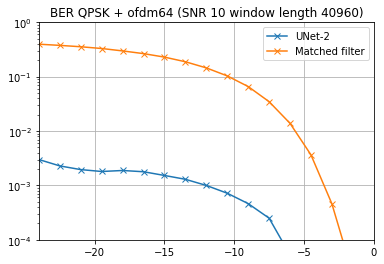

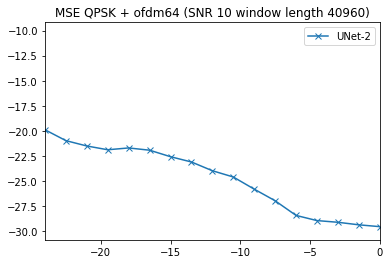

In [13]:
plt.figure()
nsim = n_per_sinr_test
plt.semilogy(all_sinr,np.array(nn_ber).reshape(-1,nsim).mean(axis=-1), 'x-', label='UNet-2')
plt.semilogy(all_sinr,np.array(mf_ber).reshape(-1,nsim).mean(axis=-1), 'x-', label='Matched filter')

plt.legend()
plt.title(f'BER QPSK + ofdm64 (SNR {target_snr} window length {window_len})')
plt.xlim(xmax = 0, xmin = -24)
plt.ylim(ymax = 1, ymin = 1e-4)
plt.grid()
# plt.savefig(f'qpsk_ofdm64_ber_sync_nopad_train_{window_len}_TS_{training_examples}_cond_1.pdf')

plt.figure()
SIR_values = np.arange(-24, 1.5, 1.5)
plt.plot(all_sinr,np.array(nn_mse).reshape(-1,nsim).mean(axis=-1), 'x-', label='UNet-2')

plt.legend()
plt.title(f'MSE QPSK + ofdm64 (SNR {target_snr} window length {window_len})')
plt.xlim(xmax = 0, xmin = -24)
# plt.ylim(ymax = 1, ymin = 1e-5)
# plt.savefig(f'qpsk_ofdm64_mse_sync_nopad_train_{window_len}_TS_{training_examples}_cond_1.pdf')

In [22]:
# Save BER
nn_ber_data = np.stack((all_sinr,np.array(nn_ber).reshape(-1,nsim).mean(axis=-1)),axis=1)
np.savetxt(f'data/ber_nn_noisy_SNR_{target_snr}.csv', nn_ber_data, delimiter=",")

# Save MSE:
nn_mse_cond_data = np.stack((all_sinr,np.array(nn_mse_cond).reshape(-1,nsim).mean(axis=-1)),axis=1)
np.savetxt(f'data/mse_nn_noisy_SNR_{target_snr}.csv', nn_mse_data, delimiter=",")
